In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn.linear_model

Считаем таблицу с признаками из файла features.csv.

In [2]:
features = pd.read_csv('features.csv', index_col='match_id')
features

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1450265551,1,47,4,1706,1198,17,0,1,8,...,4,3,0,-24.0,2032,0,1792,1975,48,63
114403,1450277704,0,43,4,1793,1416,17,0,1,5,...,3,2,0,-17.0,1734,1,2038,6,63,3
114404,1450291848,1,98,4,1399,540,1,0,0,5,...,1,3,1,-15.0,2906,0,1796,1846,51,63


Целевая переменная — radiant_win.

In [3]:
y = features['radiant_win']

Удалить признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [4]:
features.drop(['duration', 'radiant_win','tower_status_radiant', 'tower_status_dire',
               'barracks_status_radiant', 'barracks_status_dire'], axis='columns', inplace=True)

Проверить выборку на наличие пропусков.

In [5]:
features.count()[np.where(features.count()<np.max(features.count()))[0]]

first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

В 12 признаках имеется лишь от 53243 до 96538 значений из 97230 значений.
Для признака 'radiant_bottle_time' пропуски означают, что лишь в 81539/97230 игр команды преобретают предмет 'bottle' в первые 5 минут игры.
Аналогично, для признака 'radiant_first_ward_time' пропуски означают, что установки командой первого "наблюдателя" (в первые 5 минут игры) происходят в 95394/97320 игр и т.д.

Необходимо заменить пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака.

In [6]:
features.fillna(0, inplace=True)

Подход 1: градиентный бустинг над решающими деревьями

Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируем генератор разбиений для кросс-валидации по 5 блокам, не забудем перемешать при этом выборку, поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оценим качество градиентного бустинга с помощью данной кросс-валидации, попробуем при этом разное количество деревьев (10, 20, 30, 40, 50, 200).

In [7]:
kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
trees = list(np.arange(10,51,10))
trees.append(200)
qualities = []
for tree in trees:
    estimator = sklearn.ensemble.GradientBoostingClassifier(n_estimators=tree, verbose=True,
                                                            random_state=0, learning_rate=0.1)
    start_time = datetime.datetime.now()
    quality = sklearn.model_selection.cross_val_score(estimator, features, y, cv=kf, scoring='roc_auc')
    print(f'Time elapsed: {(datetime.datetime.now() - start_time)}')
    quality = np.mean(quality)
    print(f'{tree} trees yield ROC-AUC = {quality:.4f}')
    qualities.append(quality)

      Iter       Train Loss   Remaining Time 
         1           1.3788           11.25s
         2           1.3732            9.54s
         3           1.3681            8.53s
         4           1.3637            7.12s
         5           1.3591            6.03s
         6           1.3545            4.87s
         7           1.3500            3.50s
         8           1.3457            2.23s
         9           1.3417            1.07s
        10           1.3378            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3786            6.64s
         2           1.3731            5.80s
         3           1.3684            5.08s
         4           1.3640            4.33s
         5           1.3590            3.60s
         6           1.3548            2.91s
         7           1.3505            2.19s
         8           1.3461            1.45s
         9           1.3422            0.74s
        10           1.3386            0.00s
      It

         1           1.3788           27.82s
         2           1.3732           27.07s
         3           1.3681           26.31s
         4           1.3637           25.53s
         5           1.3591           24.87s
         6           1.3545           24.17s
         7           1.3500           23.44s
         8           1.3457           22.73s
         9           1.3417           22.00s
        10           1.3378           21.29s
        20           1.3083           14.03s
        30           1.2879            6.99s
        40           1.2733            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3786           28.07s
         2           1.3731           27.19s
         3           1.3684           26.35s
         4           1.3640           25.61s
         5           1.3590           24.87s
         6           1.3548           24.18s
         7           1.3505           23.42s
         8           1.3461           22.75s
         

        60           1.2535            1.63m
        70           1.2459            1.51m
        80           1.2397            1.40m
        90           1.2345            1.28m
       100           1.2298            1.16m
       200           1.1989            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3784            2.47m
         2           1.3729            2.39m
         3           1.3677            2.37m
         4           1.3631            2.36m
         5           1.3588            2.37m
         6           1.3542            2.35m
         7           1.3499            2.33m
         8           1.3458            2.31m
         9           1.3416            2.30m
        10           1.3378            2.28m
        20           1.3082            2.12m
        30           1.2882            1.99m
        40           1.2735            1.87m
        50           1.2621            1.75m
        60           1.2531            1.63m
        7

Кросс-валидация для градиентного бустинга с 30 деревьями проводилась 1 минуту 46 секунд (c округлением до целых) и дала величину метрики ROC-AUC = 0.6886 (с округлением до десятитысячных).

Визуализировать метрику качества (ROC-AUC) от количества деревьев

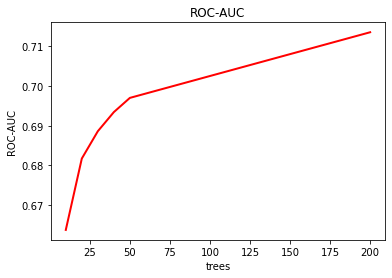

In [8]:
plt.figure()
plt.plot(trees, qualities, 'r', linewidth=2)
plt.title('ROC-AUC')
plt.ylabel('ROC-AUC')
plt.xlabel('trees')
plt.show()

Качество растет при увеличении количества деревьев. Однако, при использовании более 50 деревьев качество увеличивается незначительно, а время исполнения алгоритма сильно увеличивается, поэтому увеличивать количество деревьев далее нецелесообразно. Чтобы ускорить градиентный бустинг при увеличении количества деревьев можно уменьшить ограничение на глубину деревьев в градиентом бустинге.

Подход 2: логистическая регрессия

Выполним масштабирование.

In [9]:
scaled_ftrs = sklearn.preprocessing.StandardScaler().fit_transform(features)

Оценим качество логистической регрессии с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберем при этом лучший параметр регуляризации C. Какое наилучшее качество получилось? Как оно соотносится с качеством градиентного бустинга? Чем объясняется разница? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [10]:
c_vals = np.power(10.0, np.arange(-5, 6))
qualities_logreg = []
for c in c_vals:
    est = sklearn.linear_model.LogisticRegression(penalty='l2', C=c, random_state=0, verbose=True)
    start_time = datetime.datetime.now()
    quality = sklearn.model_selection.cross_val_score(est, scaled_ftrs, y, cv=kf, scoring='roc_auc')
    print(f'Time elapsed: {(datetime.datetime.now() - start_time)}')
    quality = np.mean(quality)
    print(f'C = {c}; ROC-AUC = {quality:.4f}')
    qualities_logreg.append(quality)
print('Logistic regression:')
print(f'Best C = {c_vals[np.argmax(qualities_logreg)]}; Best ROC-AUC = {np.max(qualities_logreg):.4f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Time elapsed: 0:00:01.397065
C = 1e-05; ROC-AUC = 0.6950


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:01.735447
C = 0.0001; ROC-AUC = 0.7112


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:03.182258
C = 0.001; ROC-AUC = 0.7161


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.081447
C = 0.01; ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.448309
C = 0.1; ROC-AUC = 0.7162


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.500403
C = 1.0; ROC-AUC = 0.7162


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.443301
C = 10.0; ROC-AUC = 0.7162


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.652312
C = 100.0; ROC-AUC = 0.7162


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.543731
C = 1000.0; ROC-AUC = 0.7162


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.569647
C = 10000.0; ROC-AUC = 0.7162


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.406340
C = 100000.0; ROC-AUC = 0.7162
Logistic regression:
Best C = 0.01; Best ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


Наилучшее качество логистического регрессора с L2-регуляризацией обеспечивается при С = 0,01. Метрика AUC-ROC при это равна 0,7163 (с округлением до десятитысячных). Это больше, чем для рассматриваемых случаев градиентного бустинга. Это может быть объяснено правильным для логистической регрессии препроцессингом. Полученное значение метрики качества приближено к ее значению для градиентного бустинга над 200 решающими деревьями (AUC-ROC = 0,7136). Однако, логистическая регрессия требует 4 секунды времени, а градиентный бустинг над 200 деревьями - 11 минут и 50 секунд (в 178 раз больше).

Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберем их из выборки, и проведем кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.

In [11]:
to_drop_ftrs = ['lobby_type']
for i in range(1,6):
    to_drop_ftrs.append(f'r{i}_hero')
    to_drop_ftrs.append(f'd{i}_hero')
scaled_ftrs_decateg = sklearn.preprocessing.StandardScaler().fit_transform(
                                                        features.drop(to_drop_ftrs, axis='columns', inplace=False))

In [12]:
c_vals = np.power(10.0, np.arange(-5, 6))
qualities_decateg = []
for c in c_vals:
    est = sklearn.linear_model.LogisticRegression(penalty='l2', C=c, random_state=0, verbose=True)
    start_time = datetime.datetime.now()
    quality = sklearn.model_selection.cross_val_score(est, scaled_ftrs_decateg, y, cv=kf, scoring='roc_auc')
    print(f'Time elapsed: {(datetime.datetime.now() - start_time)}')
    quality = np.mean(quality)
    print(f'C = {c}; ROC-AUC = {quality:.4f}')
    qualities_decateg.append(quality)
print('Categorical features removed:')
print(f'Best C = {c_vals[np.argmax(qualities_decateg)]}; Best ROC-AUC = {np.max(qualities_decateg):.4f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:01.540504
C = 1e-05; ROC-AUC = 0.6950


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:01.643328
C = 0.0001; ROC-AUC = 0.7112


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:02.778736
C = 0.001; ROC-AUC = 0.7162


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.215172
C = 0.01; ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:03.985110
C = 0.1; ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.182338
C = 1.0; ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.088713
C = 10.0; ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.055822
C = 100.0; ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.039275
C = 1000.0; ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:03.883470
C = 10000.0; ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:04.129277
C = 100000.0; ROC-AUC = 0.7163
Categorical features removed:
Best C = 0.01; Best ROC-AUC = 0.7163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


При удалении категориальных признаков качество не изменилось (значение метрики AUC-ROC = 0.7163 при округлении до десятитысячных), это говорит о невозможности учета логистическим регрессором категориальных признаков без обработки (несмотря на их важность).

На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Можно выяснить из данных, сколько различных идентификаторов героев существует в данной игре.

In [13]:
unique_heroes = len(pd.read_csv('data/dictionaries/heroes.csv'))
print(f'Unique heroes: {unique_heroes}')

Unique heroes: 112


Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Добавим полученные признаки к числовым, которые использовались раннее.

In [14]:
X_pick = np.zeros((features.shape[0], unique_heroes))
for i, match_id in enumerate(features.index):
    for p in range(5):
        X_pick[i, features.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, features.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
heroes = pd.DataFrame(X_pick, index=features.index)
X_train = pd.concat([features, heroes], axis=1)
scaler = sklearn.preprocessing.StandardScaler()
X_train_decateg = X_train.drop(to_drop_ftrs, axis='columns', inplace=False)
X_train_decateg_scaled = scaler.fit_transform(X_train_decateg)

Проведем кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.

In [15]:
c_vals = np.power(10.0, np.arange(-5, 6))
qualities_heroes = []
for c in c_vals:
    est = sklearn.linear_model.LogisticRegression(penalty='l2', C=c, random_state=0, verbose=True)
    start_time = datetime.datetime.now()
    quality = sklearn.model_selection.cross_val_score(est, X_train_decateg_scaled, y, cv=kf, scoring='roc_auc')
    print(f'Time elapsed: {(datetime.datetime.now() - start_time)}')
    quality = np.mean(quality)
    print(f'C = {c}; ROC-AUC = {quality:.4f}')
    qualities_heroes.append(quality)
print('Heroes added:')
print(f'Best C = {c_vals[np.argmax(qualities_heroes)]}; Best ROC-AUC = {np.max(qualities_heroes):.4f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Time elapsed: 0:00:02.596421
C = 1e-05; ROC-AUC = 0.7147


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:03.101547
C = 0.0001; ROC-AUC = 0.7426


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:05.163246
C = 0.001; ROC-AUC = 0.7514


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


Time elapsed: 0:00:07.717387
C = 0.01; ROC-AUC = 0.7518


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:08.159022
C = 0.1; ROC-AUC = 0.7517


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


Time elapsed: 0:00:08.590217
C = 1.0; ROC-AUC = 0.7517


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:08.166624
C = 10.0; ROC-AUC = 0.7517


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:08.536404
C = 100.0; ROC-AUC = 0.7517


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


Time elapsed: 0:00:08.252680
C = 1000.0; ROC-AUC = 0.7517


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:08.305941
C = 10000.0; ROC-AUC = 0.7517


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Time elapsed: 0:00:08.181388
C = 100000.0; ROC-AUC = 0.7517
Heroes added:
Best C = 0.01; Best ROC-AUC = 0.7518


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


Качество улучшилось до значения 0,7518 (с округлением до десятитысячных) метрики AUC-ROC при C = 0,01. Это объясняется учетом важных информационных признаков.

Теперь можно построить предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Надо убедиться, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

Подготовка тестовой выборки.

In [16]:
features_test = pd.read_csv('features_test.csv', index_col='match_id')
features_test.fillna(0, inplace=True)
X_pick_test = np.zeros((features_test.shape[0], unique_heroes))
for i, match_id in enumerate(features_test.index):
    for p in range(5):
        X_pick_test[i, features_test.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test[i, features_test.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
heroes = pd.DataFrame(X_pick_test, index=features_test.index)
X_test = pd.concat([features_test, heroes], axis=1)
X_test_decateg = X_train.drop(to_drop_ftrs, axis='columns', inplace=False)
X_test_decateg_scaled = scaler.transform(X_test_decateg)

Лучшая модель - логистическая регрессия при С = 0,01.

In [17]:
final_estimator = sklearn.linear_model.LogisticRegression(penalty='l2', C=0.01, random_state=0, verbose=True)
final_estimator.fit(X_train_decateg_scaled, y)
pred = final_estimator.predict_proba(X_test_decateg_scaled)[:, 1]
print(f'Min win probability = {np.min(pred):.4f}; Max win probability = {np.max(pred):.4f}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Min win probability = 0.0013; Max win probability = 0.9986


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
